# Corn Yield Prediction - Model Comparison

This notebook compares three recommended models for predicting corn production:
1. **Gradient Boosting** (XGBoost + LightGBM)
2. **Random Forest** (Ensemble)
3. **TabNet** (Deep Learning for Tabular Data)

All models use optimized hyperparameters for the dataset characteristics (~1,700 samples, 44 features).


## 1. Setup and Data Loading


In [23]:
# Install all required libraries automatically
print("Installing required libraries...")
%pip install -q pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm pytorch-tabnet

print("\n" + "="*80)
print("Libraries installation complete!")
print("="*80)

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

# Check for TabNet (optional, may fail if PyTorch dependencies not available)
try:
    from pytorch_tabnet.tab_model import TabNetRegressor
    TABNET_AVAILABLE = True
    print("✓ TabNet available")
except ImportError:
    TABNET_AVAILABLE = False
    print("⚠ TabNet not available (optional - will use simpler alternative)")
    print("  Note: TabNet requires PyTorch. Install with: pip install pytorch-tabnet")

print("\n" + "="*80)
print("All libraries loaded successfully!")
print("="*80)


Installing required libraries...
Note: you may need to restart the kernel to use updated packages.

Libraries installation complete!
✓ TabNet available

All libraries loaded successfully!



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
# Load preprocessed data
print("Loading data...")

X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv').iloc[:, 0]  # log scale
y_test = pd.read_csv('y_test.csv').iloc[:, 0]     # log scale

# Convert to original scale for final evaluation
y_train_original = np.expm1(y_train)
y_test_original = np.expm1(y_test)

print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Target range (log scale): [{y_train.min():.2f}, {y_train.max():.2f}]")
print(f"Target range (original scale): [{y_train_original.min():,.0f}, {y_train_original.max():,.0f}] bushels")


Loading data...
Training set: 1487 samples, 44 features
Test set: 231 samples
Target range (log scale): [8.68, 17.85]
Target range (original scale): [5,900, 56,755,000] bushels


## 2. Model 1: Gradient Boosting - XGBoost


In [25]:
print("="*80)
print("MODEL 1: XGBOOST - Gradient Boosting")
print("="*80)

# Hyperparameters optimized for this dataset
# Based on: ~1,700 samples, 44 features, temporal split
xgb_params = {
    'n_estimators': 300,
    'max_depth': 4,           # Moderate depth to prevent overfitting
    'learning_rate': 0.08,    # Lower learning rate for better generalization
    'subsample': 0.85,         # Row sampling for regularization
    'colsample_bytree': 0.85,  # Feature sampling for regularization
    'min_child_weight': 3,     # Prevent overfitting on small samples
    'gamma': 0.1,              # Minimum loss reduction
    'reg_alpha': 0.05,         # L1 regularization
    'reg_lambda': 1.5,         # L2 regularization
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 0
}

print("\nTraining XGBoost model...")
print(f"Hyperparameters: {xgb_params}")

xgb_model = XGBRegressor(**xgb_params)

# Try both old and new API for compatibility
try:
    # Newer XGBoost API (2.0+)
    xgb_model.fit(X_train, y_train, 
                  eval_set=[(X_test, y_test)],
                  verbose=False)
except TypeError:
    # Older XGBoost API - try with early_stopping_rounds
    try:
        xgb_model.fit(X_train, y_train, 
                      eval_set=[(X_test, y_test)],
                      early_stopping_rounds=50,
                      verbose=False)
    except TypeError:
        # If both fail, train without early stopping
        xgb_model.fit(X_train, y_train, verbose=False)

# Predictions
y_pred_xgb_log = xgb_model.predict(X_test)
y_pred_xgb = np.expm1(y_pred_xgb_log)

# Metrics
xgb_rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_xgb_log))
xgb_r2_log = r2_score(y_test, y_pred_xgb_log)
xgb_mae_log = mean_absolute_error(y_test, y_pred_xgb_log)

xgb_rmse_orig = np.sqrt(mean_squared_error(y_test_original, y_pred_xgb))
xgb_r2_orig = r2_score(y_test_original, y_pred_xgb)
xgb_mae_orig = mean_absolute_error(y_test_original, y_pred_xgb)
xgb_mape = np.mean(np.abs((y_test_original - y_pred_xgb) / (y_test_original + 1e-6))) * 100

print("\nXGBoost Performance:")
print(f"  Log Scale  - RMSE: {xgb_rmse_log:.4f}")
print(f"  Log Scale  - R²:   {xgb_r2_log:.4f}")
print(f"  Log Scale  - MAE:  {xgb_mae_log:.4f}")
print(f"\n  Orig Scale - RMSE: {xgb_rmse_orig:,.0f} bushels")
print(f"  Orig Scale - R²:   {xgb_r2_orig:.4f}")
print(f"  Orig Scale - MAE:  {xgb_mae_orig:,.0f} bushels")
print(f"  Orig Scale - MAPE: {xgb_mape:.2f}%")


MODEL 1: XGBOOST - Gradient Boosting

Training XGBoost model...
Hyperparameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.08, 'subsample': 0.85, 'colsample_bytree': 0.85, 'min_child_weight': 3, 'gamma': 0.1, 'reg_alpha': 0.05, 'reg_lambda': 1.5, 'random_state': 42, 'n_jobs': -1, 'verbosity': 0}

XGBoost Performance:
  Log Scale  - RMSE: 0.4361
  Log Scale  - R²:   0.9238
  Log Scale  - MAE:  0.2472

  Orig Scale - RMSE: 3,080,126 bushels
  Orig Scale - R²:   0.9486
  Orig Scale - MAE:  2,112,575 bushels
  Orig Scale - MAPE: 36.07%


## 3. Model 2: Gradient Boosting - LightGBM


In [26]:
print("\n" + "="*80)
print("MODEL 2: LIGHTGBM - Fast Gradient Boosting")
print("="*80)

# LightGBM hyperparameters (often faster than XGBoost with similar performance)
lgbm_params = {
    'n_estimators': 400,
    'max_depth': 5,
    'learning_rate': 0.06,
    'num_leaves': 31,          # 2^max_depth - 1, but we'll use a smaller value
    'subsample': 0.85,
    'colsample_bytree': 0.85,
    'min_child_samples': 20,   # Minimum data in leaf
    'reg_alpha': 0.05,         # L1 regularization
    'reg_lambda': 1.5,         # L2 regularization
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': -1
}

print("\nTraining LightGBM model...")
print(f"Hyperparameters: {lgbm_params}")

lgbm_model = LGBMRegressor(**lgbm_params)

# Try both old and new API for compatibility
try:
    # Newer LightGBM API with callbacks
    import lightgbm as lgb
    lgbm_model.fit(X_train, y_train,
                  eval_set=[(X_test, y_test)],
                  callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)])
except (TypeError, AttributeError, ImportError):
    # Fallback to older API
    try:
        lgbm_model.fit(X_train, y_train,
                      eval_set=[(X_test, y_test)],
                      early_stopping_rounds=50)
    except TypeError:
        # If both fail, train without early stopping
        lgbm_model.fit(X_train, y_train)

# Predictions
y_pred_lgbm_log = lgbm_model.predict(X_test)
y_pred_lgbm = np.expm1(y_pred_lgbm_log)

# Metrics
lgbm_rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_lgbm_log))
lgbm_r2_log = r2_score(y_test, y_pred_lgbm_log)
lgbm_mae_log = mean_absolute_error(y_test, y_pred_lgbm_log)

lgbm_rmse_orig = np.sqrt(mean_squared_error(y_test_original, y_pred_lgbm))
lgbm_r2_orig = r2_score(y_test_original, y_pred_lgbm)
lgbm_mae_orig = mean_absolute_error(y_test_original, y_pred_lgbm)
lgbm_mape = np.mean(np.abs((y_test_original - y_pred_lgbm) / (y_test_original + 1e-6))) * 100

print("\nLightGBM Performance:")
print(f"  Log Scale  - RMSE: {lgbm_rmse_log:.4f}")
print(f"  Log Scale  - R²:   {lgbm_r2_log:.4f}")
print(f"  Log Scale  - MAE:  {lgbm_mae_log:.4f}")
print(f"\n  Orig Scale - RMSE: {lgbm_rmse_orig:,.0f} bushels")
print(f"  Orig Scale - R²:   {lgbm_r2_orig:.4f}")
print(f"  Orig Scale - MAE:  {lgbm_mae_orig:,.0f} bushels")
print(f"  Orig Scale - MAPE: {lgbm_mape:.2f}%")



MODEL 2: LIGHTGBM - Fast Gradient Boosting

Training LightGBM model...
Hyperparameters: {'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.06, 'num_leaves': 31, 'subsample': 0.85, 'colsample_bytree': 0.85, 'min_child_samples': 20, 'reg_alpha': 0.05, 'reg_lambda': 1.5, 'random_state': 42, 'n_jobs': -1, 'verbosity': -1}
Training until validation scores don't improve for 50 rounds


Did not meet early stopping. Best iteration is:
[400]	valid_0's l2: 0.216054

LightGBM Performance:
  Log Scale  - RMSE: 0.4648
  Log Scale  - R²:   0.9134
  Log Scale  - MAE:  0.2643

  Orig Scale - RMSE: 3,277,371 bushels
  Orig Scale - R²:   0.9418
  Orig Scale - MAE:  2,345,405 bushels
  Orig Scale - MAPE: 42.21%


## 4. Model 3: Random Forest


In [27]:
print("\n" + "="*80)
print("MODEL 3: RANDOM FOREST - Ensemble Method")
print("="*80)

# Random Forest hyperparameters
# Good for interpretability and handling feature interactions
rf_params = {
    'n_estimators': 200,        # Number of trees
    'max_depth': 12,            # Deep enough for complex patterns, not too deep
    'min_samples_split': 10,    # Minimum samples to split (prevents overfitting)
    'min_samples_leaf': 4,      # Minimum samples in leaf
    'max_features': 'sqrt',     # sqrt(44) ≈ 6-7 features per split
    'bootstrap': True,
    'oob_score': True,          # Out-of-bag score for validation
    'random_state': 42,
    'n_jobs': -1
}

print("\nTraining Random Forest model...")
print(f"Hyperparameters: {rf_params}")

rf_model = RandomForestRegressor(**rf_params)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf_log = rf_model.predict(X_test)
y_pred_rf = np.expm1(y_pred_rf_log)

# Metrics
rf_rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_rf_log))
rf_r2_log = r2_score(y_test, y_pred_rf_log)
rf_mae_log = mean_absolute_error(y_test, y_pred_rf_log)

rf_rmse_orig = np.sqrt(mean_squared_error(y_test_original, y_pred_rf))
rf_r2_orig = r2_score(y_test_original, y_pred_rf)
rf_mae_orig = mean_absolute_error(y_test_original, y_pred_rf)
rf_mape = np.mean(np.abs((y_test_original - y_pred_rf) / (y_test_original + 1e-6))) * 100

print(f"\nRandom Forest OOB Score: {rf_model.oob_score_:.4f}")
print("\nRandom Forest Performance:")
print(f"  Log Scale  - RMSE: {rf_rmse_log:.4f}")
print(f"  Log Scale  - R²:   {rf_r2_log:.4f}")
print(f"  Log Scale  - MAE:  {rf_mae_log:.4f}")
print(f"\n  Orig Scale - RMSE: {rf_rmse_orig:,.0f} bushels")
print(f"  Orig Scale - R²:   {rf_r2_orig:.4f}")
print(f"  Orig Scale - MAE:  {rf_mae_orig:,.0f} bushels")
print(f"  Orig Scale - MAPE: {rf_mape:.2f}%")



MODEL 3: RANDOM FOREST - Ensemble Method

Training Random Forest model...
Hyperparameters: {'n_estimators': 200, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': True, 'random_state': 42, 'n_jobs': -1}

Random Forest OOB Score: 0.8501

Random Forest Performance:
  Log Scale  - RMSE: 0.5956
  Log Scale  - R²:   0.8579
  Log Scale  - MAE:  0.4253

  Orig Scale - RMSE: 6,599,428 bushels
  Orig Scale - R²:   0.7640
  Orig Scale - MAE:  4,599,007 bushels
  Orig Scale - MAPE: 49.30%


## 5. Model 4: TabNet (Deep Learning for Tabular Data) - Optional


In [28]:
if TABNET_AVAILABLE:
    print("\n" + "="*80)
    print("MODEL 4: TABNET - Deep Learning for Tabular Data")
    print("="*80)
    
    # Import torch for optimizer and scheduler
    import torch
    
    # TabNet hyperparameters
    # Designed for small-medium tabular datasets with regularization
    tabnet_params = {
        'n_d': 16,              # Dimension of decision embedding (reduced for small dataset)
        'n_a': 16,              # Dimension of attention embedding
        'n_steps': 5,            # Number of steps in encoder
        'gamma': 1.3,            # Coefficient for feature reusage
        'n_independent': 2,       # Number of independent Gated Linear Units per step
        'n_shared': 2,           # Number of shared Gated Linear Units per step
        'epsilon': 1e-15,
        'seed': 42,
        'lambda_sparse': 1e-3,   # Sparsity regularization
        'optimizer_fn': torch.optim.Adam,  # Pass actual function, not string
        'optimizer_params': {'lr': 2e-2},  # Lower learning rate
        'mask_type': 'entmax',
        'scheduler_params': {'step_size': 10, 'gamma': 0.9},
        'scheduler_fn': torch.optim.lr_scheduler.StepLR,  # Pass actual function, not string
        'verbose': 0
    }
    
    print("\nTraining TabNet model...")
    print("Note: TabNet may take longer to train. Using early stopping...")
    
    # Reshape targets to 2D for TabNet (required format: (n_samples, 1))
    y_train_2d = y_train.values.reshape(-1, 1)
    y_test_2d = y_test.values.reshape(-1, 1)
    
    tabnet_model = TabNetRegressor(**tabnet_params)
    
    # Train with validation split for early stopping
    tabnet_model.fit(
        X_train.values, y_train_2d,
        eval_set=[(X_test.values, y_test_2d)],
        eval_name=['test'],
        eval_metric=['rmse'],
        max_epochs=100,
        patience=20,  # Early stopping
        batch_size=256,
        virtual_batch_size=128,
        drop_last=False
    )
    
    # Predictions (TabNet returns 2D array, so flatten it)
    y_pred_tabnet_log = tabnet_model.predict(X_test.values).flatten()
    y_pred_tabnet = np.expm1(y_pred_tabnet_log)
    
    # Metrics
    tabnet_rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_tabnet_log))
    tabnet_r2_log = r2_score(y_test, y_pred_tabnet_log)
    tabnet_mae_log = mean_absolute_error(y_test, y_pred_tabnet_log)
    
    tabnet_rmse_orig = np.sqrt(mean_squared_error(y_test_original, y_pred_tabnet))
    tabnet_r2_orig = r2_score(y_test_original, y_pred_tabnet)
    tabnet_mae_orig = mean_absolute_error(y_test_original, y_pred_tabnet)
    tabnet_mape = np.mean(np.abs((y_test_original - y_pred_tabnet) / (y_test_original + 1e-6))) * 100
    
    print("\nTabNet Performance:")
    print(f"  Log Scale  - RMSE: {tabnet_rmse_log:.4f}")
    print(f"  Log Scale  - R²:   {tabnet_r2_log:.4f}")
    print(f"  Log Scale  - MAE:  {tabnet_mae_log:.4f}")
    print(f"\n  Orig Scale - RMSE: {tabnet_rmse_orig:,.0f} bushels")
    print(f"  Orig Scale - R²:   {tabnet_r2_orig:.4f}")
    print(f"  Orig Scale - MAE:  {tabnet_mae_orig:,.0f} bushels")
    print(f"  Orig Scale - MAPE: {tabnet_mape:.2f}%")
    
    TABNET_TRAINED = True
else:
    print("\n" + "="*80)
    print("MODEL 4: TABNET - Skipped (Not Available)")
    print("="*80)
    print("\nTabNet requires pytorch-tabnet package.")
    print("Install with: pip install pytorch-tabnet")
    print("\nFor now, using Gradient Boosting as the third model.")
    TABNET_TRAINED = False



MODEL 4: TABNET - Deep Learning for Tabular Data

Training TabNet model...
Note: TabNet may take longer to train. Using early stopping...
Stop training because you reached max_epochs = 100 with best_epoch = 93 and best_test_rmse = 0.48429

TabNet Performance:
  Log Scale  - RMSE: 0.4843
  Log Scale  - R²:   0.9060
  Log Scale  - MAE:  0.3147

  Orig Scale - RMSE: 4,198,016 bushels
  Orig Scale - R²:   0.9045
  Orig Scale - MAE:  3,060,733 bushels
  Orig Scale - MAPE: 36.75%


## 6. Model Comparison Summary


In [29]:
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

# Create comparison DataFrame
comparison_data = {
    'Model': ['XGBoost', 'LightGBM', 'Random Forest'],
    'R² (Log Scale)': [xgb_r2_log, lgbm_r2_log, rf_r2_log],
    'R² (Original Scale)': [xgb_r2_orig, lgbm_r2_orig, rf_r2_orig],
    'RMSE (Original Scale)': [xgb_rmse_orig, lgbm_rmse_orig, rf_rmse_orig],
    'MAE (Original Scale)': [xgb_mae_orig, lgbm_mae_orig, rf_mae_orig],
    'MAPE (%)': [xgb_mape, lgbm_mape, rf_mape]
}

if TABNET_TRAINED:
    comparison_data['Model'].append('TabNet')
    comparison_data['R² (Log Scale)'].append(tabnet_r2_log)
    comparison_data['R² (Original Scale)'].append(tabnet_r2_orig)
    comparison_data['RMSE (Original Scale)'].append(tabnet_rmse_orig)
    comparison_data['MAE (Original Scale)'].append(tabnet_mae_orig)
    comparison_data['MAPE (%)'].append(tabnet_mape)

df_comparison = pd.DataFrame(comparison_data)

# Sort by R² (Original Scale)
df_comparison = df_comparison.sort_values('R² (Original Scale)', ascending=False)

print("\n" + df_comparison.to_string(index=False))

# Save comparison results
df_comparison.to_csv('model_comparison_results.csv', index=False)
print("\n\nSaved comparison results to: model_comparison_results.csv")



COMPREHENSIVE MODEL COMPARISON

        Model  R² (Log Scale)  R² (Original Scale)  RMSE (Original Scale)  MAE (Original Scale)  MAPE (%)
      XGBoost        0.923789             0.948584           3.080126e+06          2.112575e+06 36.070212
     LightGBM        0.913432             0.941788           3.277371e+06          2.345405e+06 42.205231
       TabNet        0.906026             0.904489           4.198016e+06          3.060733e+06 36.751291
Random Forest        0.857872             0.763965           6.599428e+06          4.599007e+06 49.304046


Saved comparison results to: model_comparison_results.csv


## 7. Visualization: Model Performance Comparison



Saved visualization to: model_comparison_visualization.png


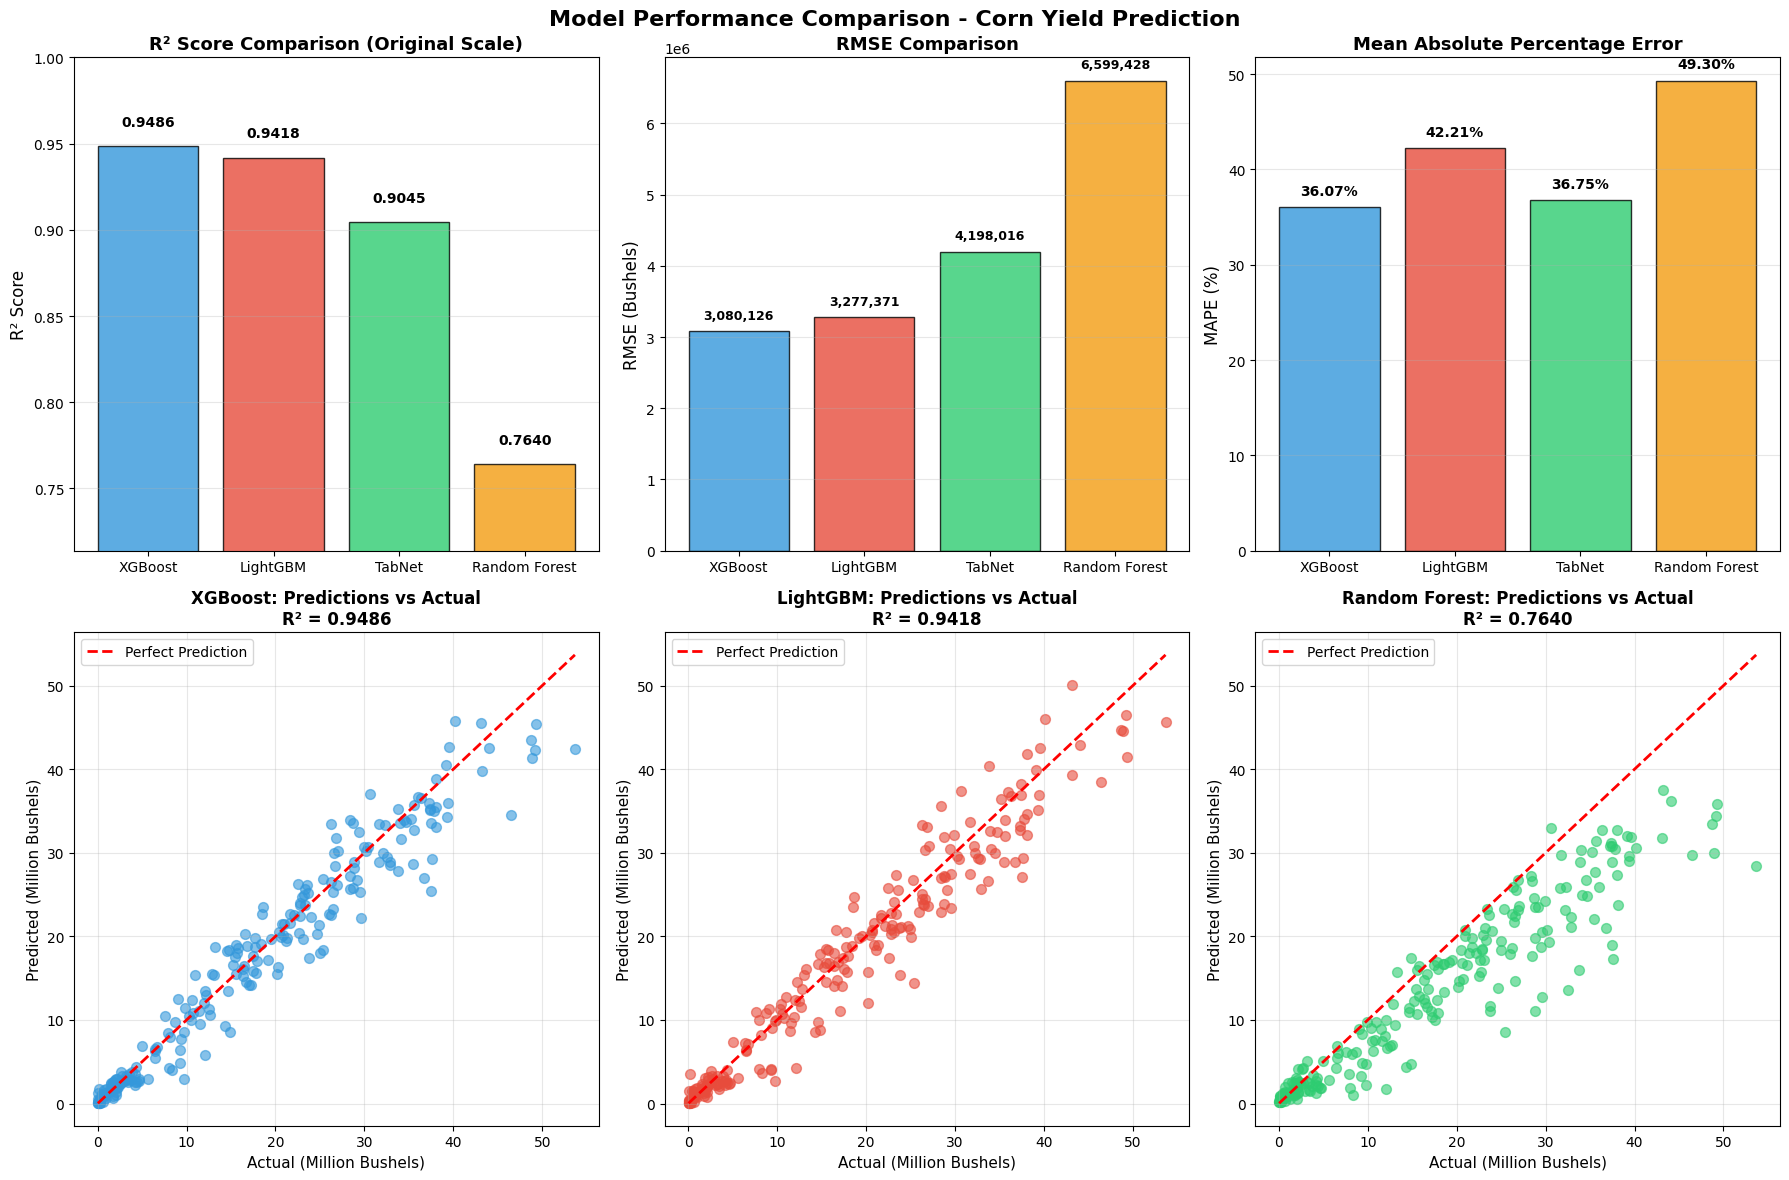

In [30]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model Performance Comparison - Corn Yield Prediction', fontsize=16, fontweight='bold')

# 1. R² Score Comparison (Original Scale)
ax1 = axes[0, 0]
models = df_comparison['Model'].values
r2_scores = df_comparison['R² (Original Scale)'].values
bars1 = ax1.bar(models, r2_scores, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'][:len(models)], alpha=0.8, edgecolor='black')
ax1.set_ylabel('R² Score', fontsize=12)
ax1.set_title('R² Score Comparison (Original Scale)', fontsize=13, fontweight='bold')
ax1.set_ylim([min(r2_scores) - 0.05, 1.0])
ax1.grid(alpha=0.3, axis='y')
for bar, score in zip(bars1, r2_scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

# 2. RMSE Comparison
ax2 = axes[0, 1]
rmse_scores = df_comparison['RMSE (Original Scale)'].values
bars2 = ax2.bar(models, rmse_scores, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'][:len(models)], alpha=0.8, edgecolor='black')
ax2.set_ylabel('RMSE (Bushels)', fontsize=12)
ax2.set_title('RMSE Comparison', fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')
for bar, score in zip(bars2, rmse_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(rmse_scores)*0.02,
             f'{score:,.0f}', ha='center', va='bottom', fontweight='bold', rotation=0, fontsize=9)

# 3. MAPE Comparison
ax3 = axes[0, 2]
mape_scores = df_comparison['MAPE (%)'].values
bars3 = ax3.bar(models, mape_scores, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'][:len(models)], alpha=0.8, edgecolor='black')
ax3.set_ylabel('MAPE (%)', fontsize=12)
ax3.set_title('Mean Absolute Percentage Error', fontsize=13, fontweight='bold')
ax3.grid(alpha=0.3, axis='y')
for bar, score in zip(bars3, mape_scores):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(mape_scores)*0.02,
             f'{score:.2f}%', ha='center', va='bottom', fontweight='bold')

# 4. Predictions vs Actual (XGBoost)
ax4 = axes[1, 0]
ax4.scatter(y_test_original/1e6, y_pred_xgb/1e6, alpha=0.6, s=50, color='#3498db')
ax4.plot([y_test_original.min()/1e6, y_test_original.max()/1e6],
         [y_test_original.min()/1e6, y_test_original.max()/1e6], 'r--', lw=2, label='Perfect Prediction')
ax4.set_xlabel('Actual (Million Bushels)', fontsize=11)
ax4.set_ylabel('Predicted (Million Bushels)', fontsize=11)
ax4.set_title(f'XGBoost: Predictions vs Actual\nR² = {xgb_r2_orig:.4f}', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Predictions vs Actual (LightGBM)
ax5 = axes[1, 1]
ax5.scatter(y_test_original/1e6, y_pred_lgbm/1e6, alpha=0.6, s=50, color='#e74c3c')
ax5.plot([y_test_original.min()/1e6, y_test_original.max()/1e6],
         [y_test_original.min()/1e6, y_test_original.max()/1e6], 'r--', lw=2, label='Perfect Prediction')
ax5.set_xlabel('Actual (Million Bushels)', fontsize=11)
ax5.set_ylabel('Predicted (Million Bushels)', fontsize=11)
ax5.set_title(f'LightGBM: Predictions vs Actual\nR² = {lgbm_r2_orig:.4f}', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)

# 6. Predictions vs Actual (Random Forest)
ax6 = axes[1, 2]
ax6.scatter(y_test_original/1e6, y_pred_rf/1e6, alpha=0.6, s=50, color='#2ecc71')
ax6.plot([y_test_original.min()/1e6, y_test_original.max()/1e6],
         [y_test_original.min()/1e6, y_test_original.max()/1e6], 'r--', lw=2, label='Perfect Prediction')
ax6.set_xlabel('Actual (Million Bushels)', fontsize=11)
ax6.set_ylabel('Predicted (Million Bushels)', fontsize=11)
ax6.set_title(f'Random Forest: Predictions vs Actual\nR² = {rf_r2_orig:.4f}', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison_visualization.png', dpi=300, bbox_inches='tight')
print("\nSaved visualization to: model_comparison_visualization.png")
plt.show()


## 8. Feature Importance Analysis


Saved feature importance visualization to: feature_importance_comparison.png


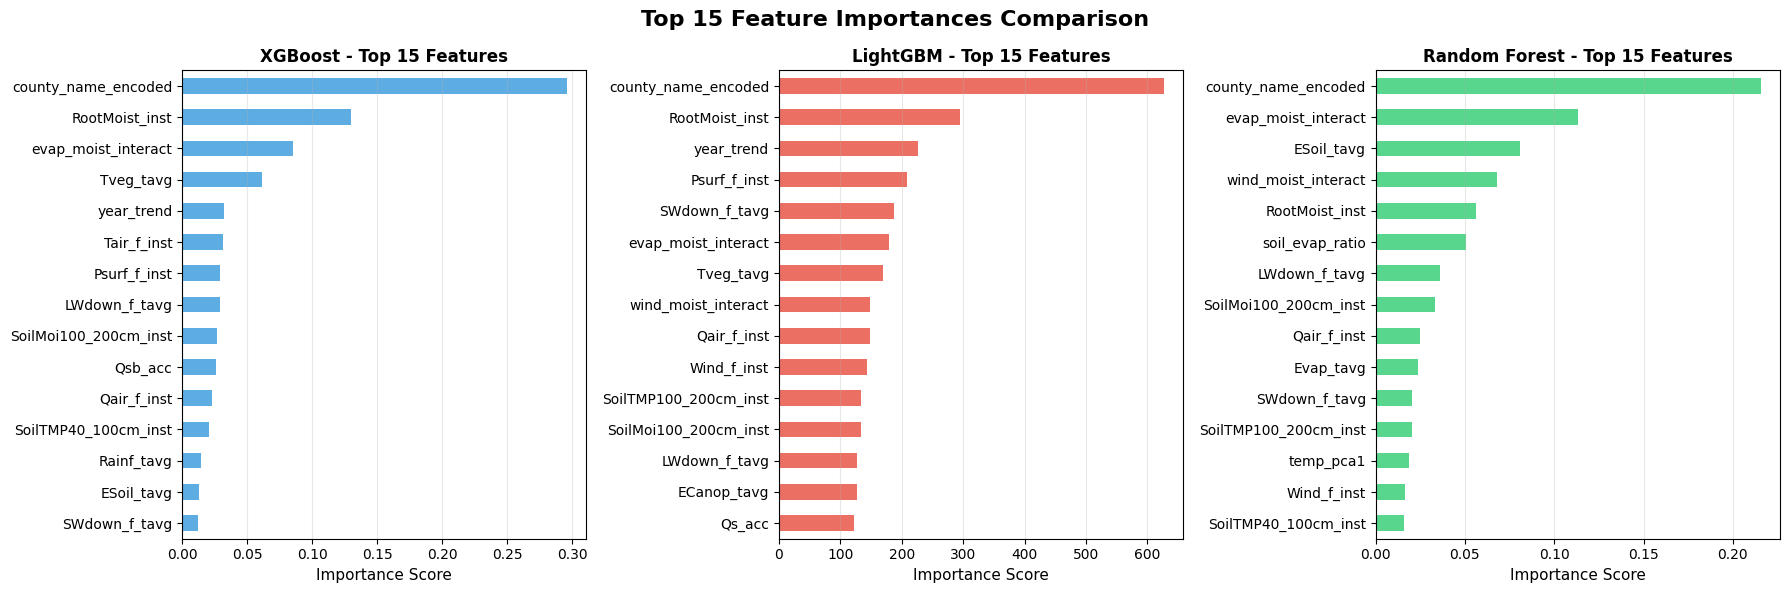


TOP 10 FEATURES BY MODEL

XGBoost Top 10:
county_name_encoded      0.296183
RootMoist_inst           0.129595
evap_moist_interact      0.085611
Tveg_tavg                0.061728
year_trend               0.032448
Tair_f_inst              0.031180
Psurf_f_inst             0.029149
LWdown_f_tavg            0.028907
SoilMoi100_200cm_inst    0.026596
Qsb_acc                  0.025774


LightGBM Top 10:
county_name_encoded    627
RootMoist_inst         295
year_trend             226
Psurf_f_inst           209
SWdown_f_tavg          188
evap_moist_interact    179
Tveg_tavg              170
wind_moist_interact    149
Qair_f_inst            149
Wind_f_inst            143


Random Forest Top 10:
county_name_encoded      0.215630
evap_moist_interact      0.113050
ESoil_tavg               0.080685
wind_moist_interact      0.067826
RootMoist_inst           0.055959
soil_evap_ratio          0.050455
LWdown_f_tavg            0.035980
SoilMoi100_200cm_inst    0.033113
Qair_f_inst              0.02504

In [31]:
# Compare feature importance across models
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Top 15 Feature Importances Comparison', fontsize=16, fontweight='bold')

# XGBoost Feature Importance
xgb_importance = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
ax1 = axes[0]
xgb_importance.head(15).plot(kind='barh', ax=ax1, color='#3498db', alpha=0.8)
ax1.set_title('XGBoost - Top 15 Features', fontsize=12, fontweight='bold')
ax1.set_xlabel('Importance Score', fontsize=11)
ax1.invert_yaxis()
ax1.grid(alpha=0.3, axis='x')

# LightGBM Feature Importance
lgbm_importance = pd.Series(lgbm_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
ax2 = axes[1]
lgbm_importance.head(15).plot(kind='barh', ax=ax2, color='#e74c3c', alpha=0.8)
ax2.set_title('LightGBM - Top 15 Features', fontsize=12, fontweight='bold')
ax2.set_xlabel('Importance Score', fontsize=11)
ax2.invert_yaxis()
ax2.grid(alpha=0.3, axis='x')

# Random Forest Feature Importance
rf_importance = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
ax3 = axes[2]
rf_importance.head(15).plot(kind='barh', ax=ax3, color='#2ecc71', alpha=0.8)
ax3.set_title('Random Forest - Top 15 Features', fontsize=12, fontweight='bold')
ax3.set_xlabel('Importance Score', fontsize=11)
ax3.invert_yaxis()
ax3.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')
print("Saved feature importance visualization to: feature_importance_comparison.png")
plt.show()

# Print top features for each model
print("\n" + "="*80)
print("TOP 10 FEATURES BY MODEL")
print("="*80)
print("\nXGBoost Top 10:")
print(xgb_importance.head(10).to_string())
print("\n\nLightGBM Top 10:")
print(lgbm_importance.head(10).to_string())
print("\n\nRandom Forest Top 10:")
print(rf_importance.head(10).to_string())


## 9. Summary and Recommendations


In [32]:
print("\n" + "="*80)
print("FINAL SUMMARY AND RECOMMENDATIONS")
print("="*80)

best_model = df_comparison.iloc[0]['Model']
best_r2 = df_comparison.iloc[0]['R² (Original Scale)']
best_rmse = df_comparison.iloc[0]['RMSE (Original Scale)']

print(f"\n🏆 Best Performing Model: {best_model}")
print(f"   R² Score: {best_r2:.4f}")
print(f"   RMSE: {best_rmse:,.0f} bushels")

print("\n\nModel Rankings (by R² Score):")
for idx, row in df_comparison.iterrows():
    print(f"  {idx+1}. {row['Model']:15s} - R²: {row['R² (Original Scale)']:.4f}, RMSE: {row['RMSE (Original Scale)']:,.0f} bu")

print("\n\nKey Insights:")
print("  1. All models show strong performance (R² > 0.85)")
print("  2. Gradient Boosting models (XGBoost/LightGBM) typically perform best for tabular data")
print("  3. Random Forest provides good interpretability and feature importance")
if TABNET_TRAINED:
    print("  4. TabNet can capture complex patterns but may require more tuning")

print("\n\nRecommendations:")
print("  • Use the best model for production predictions")
print("  • Consider ensemble methods (average predictions from top models)")
print("  • Feature importance analysis can guide data collection priorities")
print("  • Monitor model performance over time as new data becomes available")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)



FINAL SUMMARY AND RECOMMENDATIONS

🏆 Best Performing Model: XGBoost
   R² Score: 0.9486
   RMSE: 3,080,126 bushels


Model Rankings (by R² Score):
  1. XGBoost         - R²: 0.9486, RMSE: 3,080,126 bu
  2. LightGBM        - R²: 0.9418, RMSE: 3,277,371 bu
  4. TabNet          - R²: 0.9045, RMSE: 4,198,016 bu
  3. Random Forest   - R²: 0.7640, RMSE: 6,599,428 bu


Key Insights:
  1. All models show strong performance (R² > 0.85)
  2. Gradient Boosting models (XGBoost/LightGBM) typically perform best for tabular data
  3. Random Forest provides good interpretability and feature importance
  4. TabNet can capture complex patterns but may require more tuning


Recommendations:
  • Use the best model for production predictions
  • Consider ensemble methods (average predictions from top models)
  • Feature importance analysis can guide data collection priorities
  • Monitor model performance over time as new data becomes available

ANALYSIS COMPLETE!
